In [659]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn import tree

import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
import torch.nn as nn
from mpl_toolkits.mplot3d import Axes3D  
import plotly.graph_objects as go
from scipy.stats import gaussian_kde
import matplotlib.patches as mpatches
import matplotlib.dates as mdates


In [622]:
data = pd.read_csv('./Dataset_dumarey/original_csv/dataset_rounded.csv')

#### Dataset overview

In [623]:
data.head()


,vm,timestamp,end_time,odo,end_odo,soc,end_soc,event,charge_mode
0,-8.99632E+l8,01/01/2021 20:31,01/01/2021 20:38,"443,664","443,947",564.0,549.0,trip,NaN
1,-8.99632E+ 18,01/01/202120:39,02/01/202115:13,"443,947","443,947",549.0,100.0,charge,240
2,-8.99632E+18,02/01/202115:13,02/01/202115:21,"443,947","444,250",100.0,100.0,trip,NaN
3,-8.99632E+18,02/01/202115:21,02/01/202117:46,"444,250","445,713",100.0,945.0,trip,NaN
4,-8.99632E+18,02/01/202117:46,02/01/202117:53,"445,713","446,145",945.0,945.0,trip,NaN


In [624]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   vm           32 non-null     object 
 1   timestamp    32 non-null     object 
 2   end_time     32 non-null     object 
 3   odo          32 non-null     object 
 4   end_odo      32 non-null     object 
 5   soc          31 non-null     float64
 6   end_soc      31 non-null     float64
 7   event        32 non-null     object 
 8   charge_mode  8 non-null      object 
dtypes: float64(2), object(7)
memory usage: 2.4+ KB


## Data Cleaning


In [625]:
def remove_comma(ts):
    if pd.isna(ts):
        return ts 
    ts = str(ts).strip()
    ts = ts.replace(",", ".")         
    ts = ts.replace(". ", ".")        
    return ts 


def fix_timestamp_format(ts):
    if pd.isna(ts):
        return ts  
    ts = str(ts).strip()
    
    if re.match(r"\d{2}/\d{2}/\d{4} \d{2}:\d{2}", ts):
        return ts
    elif re.match(r"\d{2}/\d{2}/\d{4}\d{2}:\d{2}", ts):
        return ts[:10] + ' ' + ts[10:]
    else:
        return ts 
def fix_soc (ts):
    if ts > 100.0:
        return ts / 10
    else:
        return ts
def fix_odo (ts):
    return ts * 10


#### Fixing marks

In [626]:
data['odo'] = data['odo'].apply(remove_comma)
data['end_odo'] = data['end_odo'].apply(remove_comma)
data['soc'] = data['soc'].apply(remove_comma)
data['end_soc'] = data['end_soc'].apply(remove_comma)

#### From object to float64


In [627]:
cols_to_float = ['odo', 'end_odo', 'soc', 'end_soc']
for col in cols_to_float:
    data[col] = pd.to_numeric(data[col], errors='coerce')

#### Fixing timestamp format

In [628]:
data['timestamp'] = data['timestamp'].apply(fix_timestamp_format)
data['end_time'] = data['end_time'].apply(fix_timestamp_format) 
data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce')
data['end_time'] = pd.to_datetime(data['end_time'], errors='coerce')

#### Value correction

In [629]:
data['soc'] = data['soc'].apply(fix_soc)
data['end_soc'] = data['end_soc'].apply(fix_soc)
data['odo'] = data['odo'].apply(fix_odo)
data['end_odo'] = data['end_odo'].apply(fix_odo)


#### Clean and convert (vm, event, charge_mode)

In [630]:
cols_to_convert = ['event', 'charge_mode']
for col in cols_to_convert:
    data[col] = data[col].astype('category')
data['charge_mode'] = data['charge_mode'].cat.add_categories('0').fillna('0')
data['vm'] = data['vm'].apply(lambda x: 1.0 if str(x).startswith('-8.9') else x)
data['vm'] = data['vm'].astype('Float64')

### Inspect dataset structure

In [631]:
print(f"Element of the dataset: {len(data)}")
print(f"Columns of the dataset: {data.columns.to_list()}")


Element of the dataset: 32
Columns of the dataset: ['vm', 'timestamp', 'end_time', 'odo', 'end_odo', 'soc', 'end_soc', 'event', 'charge_mode']


In [632]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   vm           32 non-null     Float64       
 1   timestamp    32 non-null     datetime64[ns]
 2   end_time     32 non-null     datetime64[ns]
 3   odo          32 non-null     float64       
 4   end_odo      32 non-null     float64       
 5   soc          31 non-null     float64       
 6   end_soc      31 non-null     float64       
 7   event        32 non-null     category      
 8   charge_mode  32 non-null     category      
dtypes: Float64(1), category(2), datetime64[ns](2), float64(4)
memory usage: 2.2 KB


In [633]:
data.head()

,vm,timestamp,end_time,odo,end_odo,soc,end_soc,event,charge_mode
0,1.0,2021-01-01 20:31:00,2021-01-01 20:38:00,4436.64,4439.47,56.4,54.9,trip,0
1,1.0,2021-01-01 20:39:00,2021-02-01 15:13:00,4439.47,4439.47,54.9,100.0,charge,240
2,1.0,2021-02-01 15:13:00,2021-02-01 15:21:00,4439.47,4442.50,100.0,100.0,trip,0
3,1.0,2021-02-01 15:21:00,2021-02-01 17:46:00,4442.50,4457.13,100.0,94.5,trip,0
4,1.0,2021-02-01 17:46:00,2021-02-01 17:53:00,4457.13,4461.45,94.5,94.5,trip,0


## Dataset statistics: missing values and duplicates

In [634]:
nan_count = data.isna().sum()
print("| Features | NaN-counter |")
print(nan_count)
print("|----------|-------------|")

| Features | NaN-counter |
vm             0
timestamp      0
end_time       0
odo            0
end_odo        0
soc            1
end_soc        1
event          0
charge_mode    0
dtype: int64
|----------|-------------|


In [635]:
duplicates = data.duplicated()
print(f"Duplicates: {duplicates.sum()}")
data = data[~duplicates]

Duplicates: 0


In [636]:
print(f"Element of the dataset: {len(data)}")

Element of the dataset: 32


### Added Duration column (end_time - timestamp) in minute

In [637]:
# add a column duration
data['duration'] = (data['end_time'] - data['timestamp']).dt.total_seconds()/60

In [638]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   vm           32 non-null     Float64       
 1   timestamp    32 non-null     datetime64[ns]
 2   end_time     32 non-null     datetime64[ns]
 3   odo          32 non-null     float64       
 4   end_odo      32 non-null     float64       
 5   soc          31 non-null     float64       
 6   end_soc      31 non-null     float64       
 7   event        32 non-null     category      
 8   charge_mode  32 non-null     category      
 9   duration     32 non-null     float64       
dtypes: Float64(1), category(2), datetime64[ns](2), float64(5)
memory usage: 2.5 KB


## Strategies for filling null values

In [639]:
#fill missing values in data with the mean of the column
imputer = SimpleImputer(strategy='mean')
def impute_missing_values(data):
    for col in data.columns:
        if data[col].dtype in ['float64', 'int64']:
            data[col] = imputer.fit_transform(data[[col]])
    return data


In [640]:
# Removing rows with NaN values for any column
def remove_nan_rows(data):
    data = data.dropna()
    return data


In [641]:
#data = impute_missing_values(data)
data = remove_nan_rows(data)

In [642]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 0 to 31
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   vm           30 non-null     Float64       
 1   timestamp    30 non-null     datetime64[ns]
 2   end_time     30 non-null     datetime64[ns]
 3   odo          30 non-null     float64       
 4   end_odo      30 non-null     float64       
 5   soc          30 non-null     float64       
 6   end_soc      30 non-null     float64       
 7   event        30 non-null     category      
 8   charge_mode  30 non-null     category      
 9   duration     30 non-null     float64       
dtypes: Float64(1), category(2), datetime64[ns](2), float64(5)
memory usage: 2.4 KB


## Summary statistics: odo, end_odo, soc, end_soc

In [643]:
# statistics of the dataset for odo, end_odo, soc, end_soc
print("Statistics of the dataset:")
data[['odo', 'end_odo', 'soc', 'end_soc']].describe().T

Statistics of the dataset:


,count,mean,std,min,25%,50%,75%,max
odo,30.0,4693.897333,185.233327,4436.64,4500.6050,4665.170,4868.4200,4973.25
end_odo,30.0,4711.720000,185.507014,4439.47,4560.2175,4666.575,4870.3175,4974.08
soc,30.0,59.210000,24.591453,16.00,46.0000,58.800,72.0000,100.00
end_soc,30.0,59.390000,24.637795,16.00,45.7000,59.200,71.9000,100.00


# Event Analysis and Statistical Characterization

## Discharge

In [644]:

trip_data = data[data['event'] == 'trip'].copy().reset_index(drop=True)
trip_data['km_driven'] = trip_data['end_odo'] - trip_data['odo']
trip_data['discharge'] = trip_data['soc'] - trip_data['end_soc']
print("📊 Statistics on driven km:\n", trip_data['km_driven'].describe())
print("\n🔋 Statistics on discharge:\n", trip_data['discharge'].describe())
print(trip_data['discharge'])

📊 Statistics on driven km:
 count     23.000000
mean      23.246957
std       38.180932
min        0.000000
25%        0.755000
50%        2.830000
75%       16.950000
max      100.440000
Name: km_driven, dtype: float64

🔋 Statistics on discharge:
 count    23.000000
mean      5.934783
std      10.242408
min      -0.400000
25%       0.000000
50%       0.800000
75%       4.900000
max      31.800000
Name: discharge, dtype: float64
0      1.5
1      0.0
2      5.5
3      0.0
4      0.0
5      4.3
6     18.9
7      0.0
8     26.6
9      0.0
10     0.0
11     1.2
12     0.8
13    23.9
14    31.8
15     0.8
16     0.0
17    -0.4
18     0.8
19     0.0
20    20.4
21     0.0
22     0.4
Name: discharge, dtype: float64


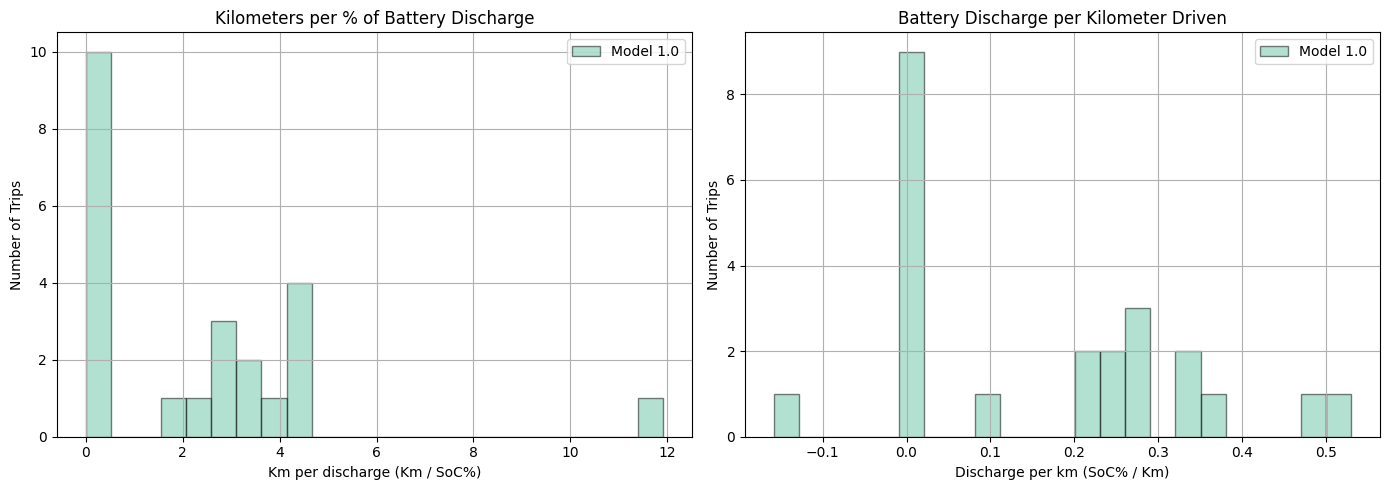

In [645]:

trip_data['km_per_perc_of_battery'] = trip_data.apply(
    lambda row: row['km_driven'] / row['discharge'] if row['discharge'] > 0 else 0,
    axis=1
)

trip_data['discharge_per_km'] = trip_data.apply(
    lambda row: row['discharge'] / row['km_driven'] if row['km_driven'] > 0 else 0,
    axis=1
)

# Setup
models = trip_data['vm'].dropna().unique()
colors = plt.get_cmap('Set2', len(models))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))


for i, model in enumerate(models):
    subset = trip_data[trip_data['vm'] == model]
    axes[0].hist(
        subset['km_per_perc_of_battery'],
        bins=len(subset),
        alpha=0.5,
        color=colors(i),
        label=f'Model {model}',
        edgecolor='black'
    )

axes[0].set_title('Kilometers per % of Battery Discharge')
axes[0].set_xlabel('Km per discharge (Km / SoC%)')
axes[0].set_ylabel('Number of Trips')
axes[0].grid(True)
axes[0].legend()

for i, model in enumerate(models):
    subset = trip_data[trip_data['vm'] == model]
    axes[1].hist(
        subset['discharge_per_km'],
        bins=len(subset),
        alpha=0.5,
        color=colors(i),
        label=f'Model {model}',
        edgecolor='black'
    )

axes[1].set_title('Battery Discharge per Kilometer Driven')
axes[1].set_xlabel('Discharge per km (SoC% / Km)')
axes[1].set_ylabel('Number of Trips')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

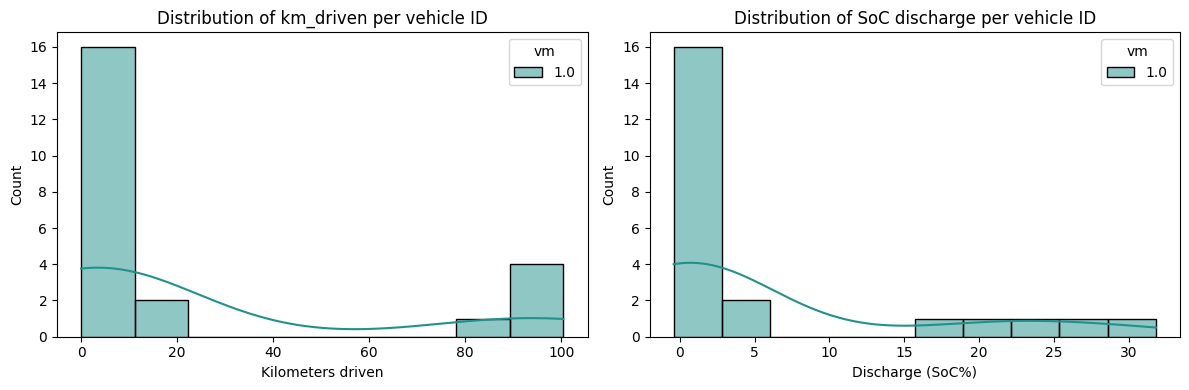

In [646]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(data=trip_data, x='km_driven', kde=True, hue='vm', palette='viridis', ax=axes[0])
axes[0].set_title('Distribution of km_driven per vehicle ID')
axes[0].set_xlabel('Kilometers driven')

sns.histplot(data=trip_data, x='discharge', kde=True, hue='vm', palette='viridis', ax=axes[1])
axes[1].set_title('Distribution of SoC discharge per vehicle ID')
axes[1].set_xlabel('Discharge (SoC%)')

plt.tight_layout()
plt.show()

In [647]:
import numpy as np
import plotly.graph_objects as go

vehicles = trip_data['vm'].unique()
colors = ['Blues', 'Reds', 'Greens', 'Purples', 'Oranges', 'Viridis'] 

fig = go.Figure()

x = trip_data['km_driven'].values
y = trip_data['discharge'].values
xedges = np.linspace(x.min(), x.max(), 31)
yedges = np.linspace(y.min(), y.max(), 31)
xcenters = 0.5 * (xedges[:-1] + xedges[1:])
ycenters = 0.5 * (yedges[:-1] + yedges[1:])
X, Y = np.meshgrid(xcenters, ycenters, indexing="ij")

for i, vm in enumerate(vehicles):
    subset = trip_data[trip_data['vm'] == vm]
    hist, _, _ = np.histogram2d(
        subset['km_driven'], subset['discharge'],
        bins=[xedges, yedges],
        density=True
    )
    
    # Surface plot
    fig.add_trace(go.Surface(
        x=X,
        y=Y,
        z=hist,
        colorscale=colors[i % len(colors)],
        showscale=False,
        name=f'Vehicle {vm}',
        opacity=0.8,
        hoverinfo="skip", 
        legendgroup=f'{vm}',  # raggruppa
        showlegend=True  
    ))

    

fig.update_layout(
    title='3D Histogram Surface of km_driven and discharge by Vehicle',
    scene=dict(
        xaxis_title='Kilometers driven',
        yaxis_title='Discharge (SoC%)',
        zaxis_title='Density'
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    legend=dict(title="Vehicles")
)

fig.show()

/Users/gabriele/Desktop/Magistrale/Tesi/env/lib/python3.13/site-packages/mpl_toolkits/mplot3d/art3d.py:1403: RuntimeWarning:

divide by zero encountered in matmul

/Users/gabriele/Desktop/Magistrale/Tesi/env/lib/python3.13/site-packages/mpl_toolkits/mplot3d/art3d.py:1403: RuntimeWarning:

overflow encountered in matmul



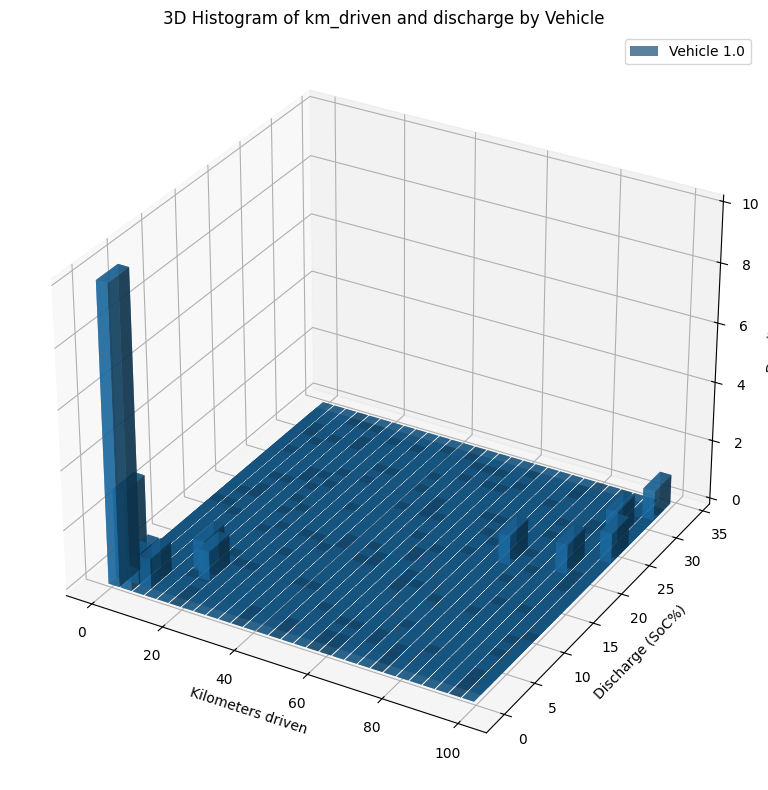

In [648]:
from matplotlib import pyplot


vehicles = trip_data['vm'].unique()
colors = pyplot.get_cmap('tab10', len(vehicles))  

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')


x = trip_data['km_driven']
y = trip_data['discharge']
xedges = np.linspace(x.min(), x.max(), 30)
yedges = np.linspace(y.min(), y.max(), 30)

dx = dy = (xedges[1] - xedges[0]) * 0.9

for i, vm in enumerate(vehicles):
    subset = trip_data[trip_data['vm'] == vm]
    hist, xedges_sub, yedges_sub = np.histogram2d(subset['km_driven'], subset['discharge'], bins=[xedges, yedges], density=False)

    xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = np.zeros_like(xpos)
    dz = hist.ravel()


    z_offset = i * dz.max() * 1.2
    zpos = zpos + z_offset

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors(i), alpha=0.7, label=f'Vehicle {vm}', shade=True)

ax.set_xlabel('Kilometers driven')
ax.set_ylabel('Discharge (SoC%)')
ax.set_zlabel('Density')
ax.set_title('3D Histogram of km_driven and discharge by Vehicle')
ax.legend()

plt.tight_layout()
plt.show()

In [649]:
vehicles = trip_data['vm'].unique()
colors = ['Viridis', 'Cividis', 'Plasma', 'Inferno', 'Magma', 'Turbo']  

fig = go.Figure()


x = trip_data['km_driven'].values
y = trip_data['discharge'].values
xgrid = np.linspace(x.min(), x.max(), 100)
ygrid = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(xgrid, ygrid)
positions = np.vstack([X.ravel(), Y.ravel()])

for i, vm in enumerate(vehicles):
    subset = trip_data[trip_data['vm'] == vm]
    xy_subset = np.vstack([subset['km_driven'].values, subset['discharge'].values])
    kde = gaussian_kde(xy_subset)
    Z = np.reshape(kde(positions).T, X.shape)
    
    fig.add_trace(go.Surface(
        x=X,
        y=Y,
        z=Z,
        colorscale=colors[i % len(colors)],
        name=f'Vehicle {vm}',
        showscale=False,
        opacity=0.8,
        showlegend=True  
    ))

fig.update_layout(
    title='3D KDE Surface of km_driven and discharge by Vehicle',
    scene=dict(
        xaxis_title='Kilometers driven',
        yaxis_title='Discharge (SoC%)',
        zaxis_title='Density'
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()

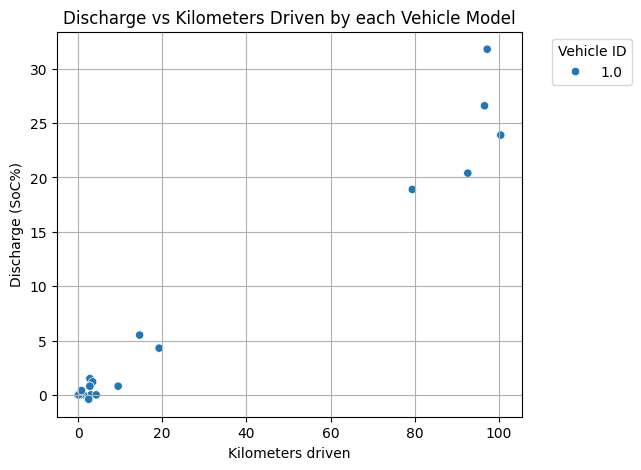

In [650]:
plt.figure(figsize=(6, 5))
sns.scatterplot(data=trip_data, x='km_driven', y='discharge',hue = 'vm', palette = 'tab10')
plt.title('Discharge vs Kilometers Driven by each Vehicle Model')
plt.legend(title='Vehicle ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Kilometers driven')
plt.ylabel('Discharge (SoC%)')
plt.grid(True)
plt.show()

#### Visualize battery discharge across driven distance for each trip

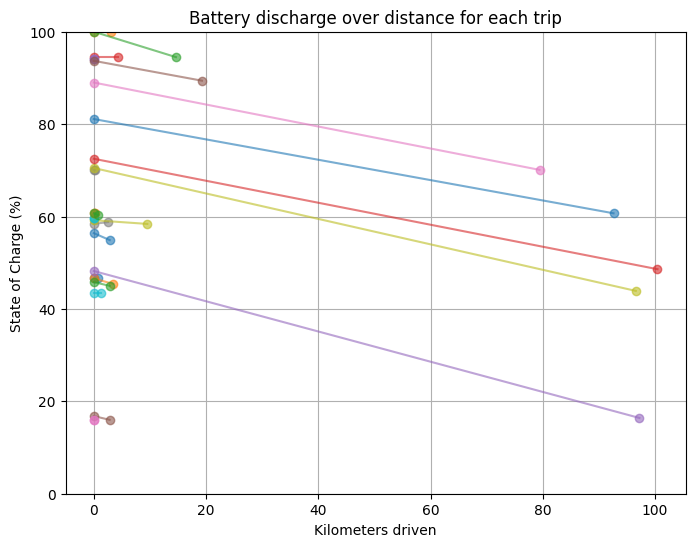

In [651]:
plt.figure(figsize=(8, 6))

for _, row in trip_data.iterrows():
    x_vals = [0, row['km_driven']]
    y_vals = [row['soc'], row['end_soc']]
    plt.plot(x_vals, y_vals, marker='o', alpha=0.6)


plt.xlabel('Kilometers driven')
plt.ylabel('State of Charge (%)')
plt.title('Battery discharge over distance for each trip')
plt.ylim(0, 100)
plt.grid(True)
plt.show()

## Charge

In [652]:
charge_data = data[data['event'] == 'charge'].copy().reset_index(drop=True)
charge_data['diff_battery'] = charge_data['end_soc'] - charge_data['soc']
print("🔋 Statistics on charge km:\n", charge_data['diff_battery'].describe())


🔋 Statistics on charge km:
 count     7.000000
mean     20.271429
std      19.256662
min       0.000000
25%       2.350000
50%      21.500000
75%      35.300000
max      45.100000
Name: diff_battery, dtype: float64


/var/folders/yf/3whxpy_91xb0fnz553qstm580000gn/T/ipykernel_27815/232348951.py:30: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



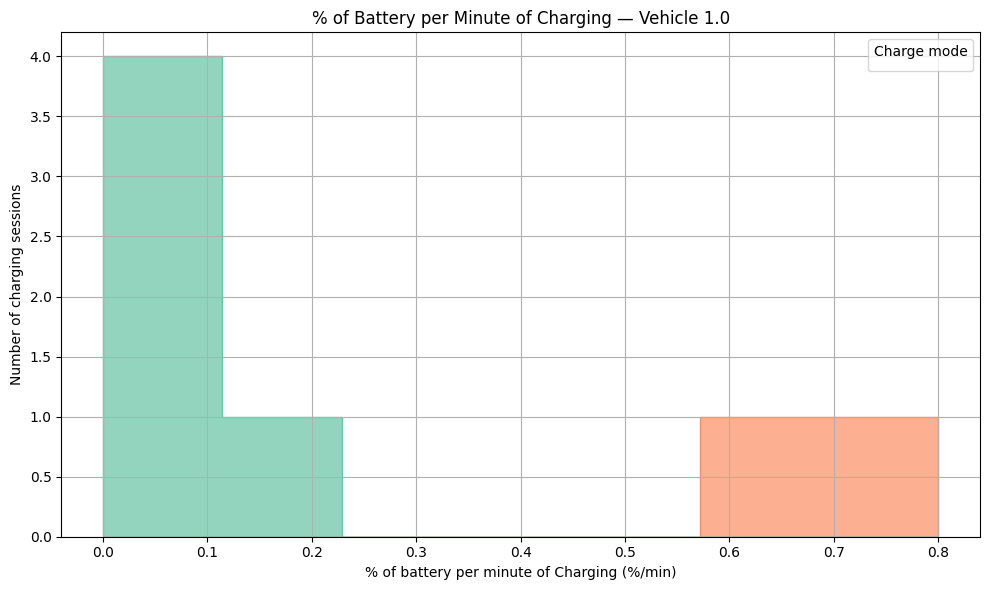

In [653]:
charge_data['perc_per_min'] = charge_data.apply(
    lambda row: row['diff_battery'] / row['duration'] if row['duration'] > 0 else 0,
    axis=1
)

vehicles = charge_data['vm'].dropna().unique()

for vm in vehicles:
    subset = charge_data[charge_data['vm'] == vm]

    if subset.empty:
        continue

    plt.figure(figsize=(10, 6))
    sns.histplot(
        data=subset,
        x='perc_per_min',
        bins=len(subset),
        hue='charge_mode',
        palette='Set2',
        element='step',
        stat='count',
        alpha=0.7
    )

    plt.title(f'% of Battery per Minute of Charging — Vehicle {vm}')
    plt.xlabel('% of battery per minute of Charging (%/min)')
    plt.ylabel('Number of charging sessions')
    plt.grid(True)
    plt.legend(title='Charge mode')
    plt.tight_layout()
    plt.show()

In [654]:
modes = charge_data['charge_mode'].dropna().unique()
colors = ['Viridis', 'Plasma', 'Cividis', 'Inferno', 'Magma', 'Turbo']

fig = go.Figure()


x = charge_data['duration'].dropna().values
y = charge_data['diff_battery'].dropna().values
xgrid = np.linspace(x.min(), x.max(), 100)
ygrid = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(xgrid, ygrid)
positions = np.vstack([X.ravel(), Y.ravel()])

for i, mode in enumerate(modes):
    subset = charge_data[charge_data['charge_mode'] == mode]
    xy_subset = np.vstack([subset['duration'].values, subset['diff_battery'].values])
    
    if xy_subset.shape[1] < 2:
        continue
    
    kde = gaussian_kde(xy_subset)
    Z = np.reshape(kde(positions).T, X.shape)
    
    fig.add_trace(go.Surface(
        x=X,
        y=Y,
        z=Z,
        colorscale=colors[i % len(colors)],
        name=f'Charge mode {mode}',
        showscale=False,
        opacity=0.8,
        showlegend=True  
    ))

fig.update_layout(
    title='3D KDE Surface of Duration and Battery Difference by Charge Mode',
    scene=dict(
        xaxis_title='Duration (minutes)',
        yaxis_title='Battery difference (SoC%)',
        zaxis_title='Density'
    ),
    legend=dict(
        title="Charge Mode",
        itemsizing='constant',
        bgcolor='rgba(255,255,255,0.8)',
        bordercolor='black',
        borderwidth=1,
        x=0.8,
        y=0.9
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()

/Users/gabriele/Desktop/Magistrale/Tesi/env/lib/python3.13/site-packages/mpl_toolkits/mplot3d/art3d.py:1403: RuntimeWarning:

divide by zero encountered in matmul

/Users/gabriele/Desktop/Magistrale/Tesi/env/lib/python3.13/site-packages/mpl_toolkits/mplot3d/art3d.py:1403: RuntimeWarning:

overflow encountered in matmul

/Users/gabriele/Desktop/Magistrale/Tesi/env/lib/python3.13/site-packages/mpl_toolkits/mplot3d/art3d.py:1403: RuntimeWarning:

divide by zero encountered in matmul

/Users/gabriele/Desktop/Magistrale/Tesi/env/lib/python3.13/site-packages/mpl_toolkits/mplot3d/art3d.py:1403: RuntimeWarning:

overflow encountered in matmul



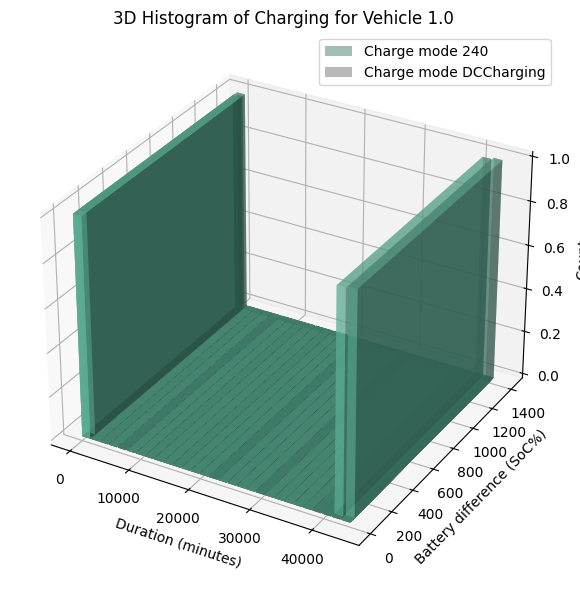

In [655]:


vehicles = charge_data['vm'].dropna().unique()
charge_modes = charge_data['charge_mode'].dropna().unique()
colors = plt.get_cmap('Set2', len(charge_modes))  

x = charge_data['duration'].dropna()
y = charge_data['diff_battery'].dropna()
xedges = np.linspace(x.min(), x.max(), 30)
yedges = np.linspace(y.min(), y.max(), 30)
dx = dy = (xedges[1] - xedges[0]) * 0.9

for vm in vehicles:
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    for i, mode in enumerate(charge_modes):
        subset = charge_data[
            (charge_data['vm'] == vm) &
            (charge_data['charge_mode'] == mode)
        ]
        if subset.empty:
            continue

        hist, _, _ = np.histogram2d(
            subset['duration'].dropna(),
            subset['diff_battery'].dropna(),
            bins=[xedges, yedges],
            density=False
        )

        xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
        xpos = xpos.ravel()
        ypos = ypos.ravel()
        zpos = np.zeros_like(xpos)
        dz = hist.ravel()

        ax.bar3d(
            xpos, ypos, zpos,
            dx, dy, dz,
            color=colors(i),
            alpha=0.5,  # più trasparente
            label=f'Charge mode {mode}',
            shade=True
        )

    ax.set_xlabel('Duration (minutes)')
    ax.set_ylabel('Battery difference (SoC%)')
    ax.set_zlabel('Count')
    ax.set_title(f'3D Histogram of Charging for Vehicle {vm}')
    ax.legend()
    plt.tight_layout()
    plt.show()

# Event timeline

In [656]:
data['event_id'] = range(1, len(data) + 1)
first_data = data['timestamp'].min() 
last_data = data['end_time'].max()

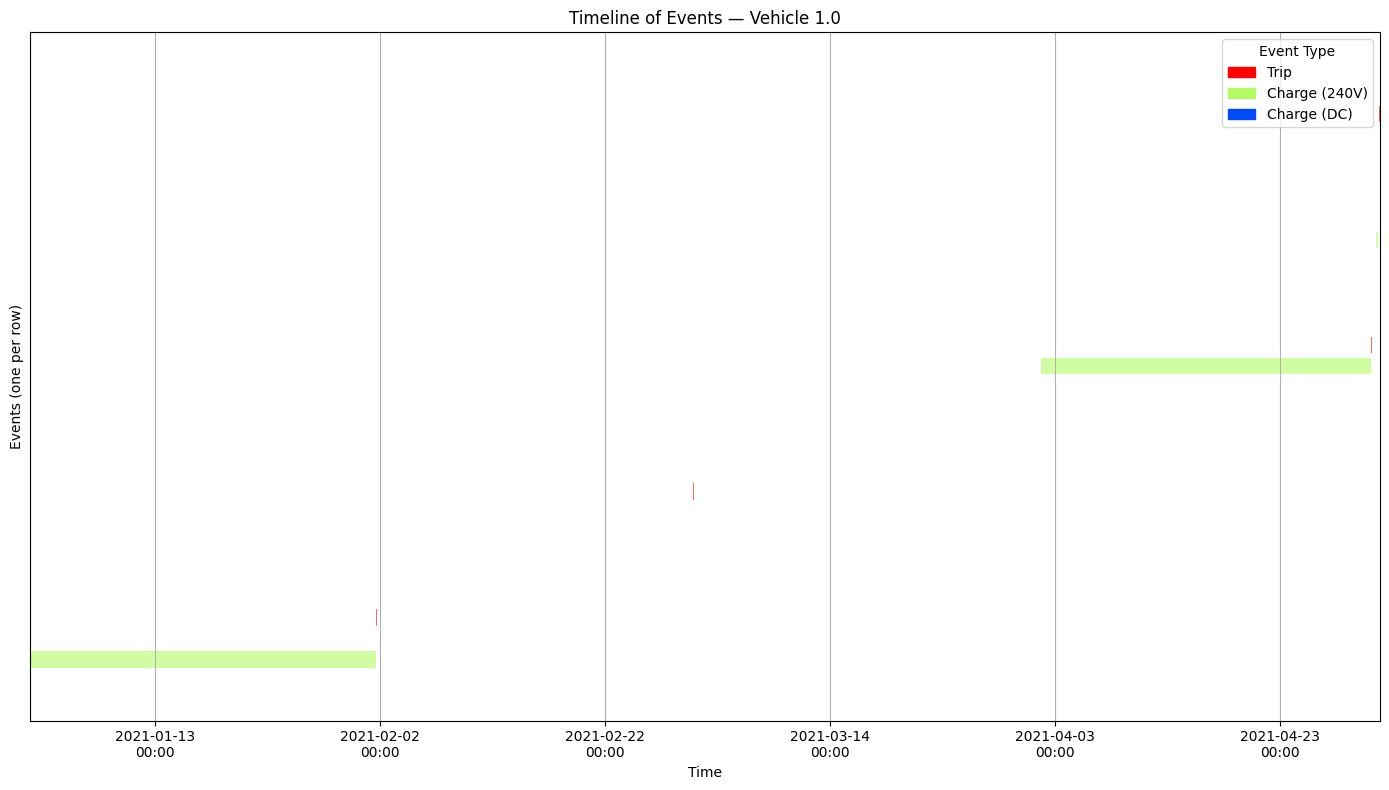

In [669]:
def event_label(row):
    if row['event'] == 'trip':
        return 'trip'
    elif row['event'] == 'charge' and str(row['charge_mode']) == '240':
        return 'charge_240'
    elif row['event'] == 'charge' and str(row['charge_mode']) == 'DCCharging':
        return 'charge_DC'
    else:
        return 'ignore'

# Colori assegnati a ogni tipo esteso (solo i tre che ci interessano)
color_map = {
    'trip': "#ff0000",
    'charge_240': "#b2fc62",
    'charge_DC': "#004af7"
}

# Lista veicoli
vehicles = data['vm'].dropna().unique()

for vm in vehicles:
    fig, ax = plt.subplots(figsize=(14, 8))
    subset = data[data['vm'] == vm].sort_values(by='timestamp').reset_index(drop=True)

    y_offset = 0
    bar_height = 8

    for _, row in subset.iterrows():
        event_type = event_label(row)
        if event_type == 'ignore':
            continue  # salta eventi non validi

        start = mdates.date2num(row['timestamp'])
        end = mdates.date2num(row['end_time'])
        duration = end - start
        color = color_map.get(event_type, 'gray')

        ax.broken_barh(
            [(start, duration)],
            (y_offset, bar_height),
            facecolors=color,
            alpha=0.6
        )
        y_offset += bar_height + 2

    # Asse X temporale
    ax.set_xlim(mdates.date2num(first_data), mdates.date2num(last_data))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
    ax.set_xlabel('Time')
    ax.set_ylabel('Events (one per row)')
    ax.set_title(f'Timeline of Events — Vehicle {vm}')
    ax.grid(True)
    ax.set_yticks([])

    # Legenda
    legend_labels = {
        'trip': 'Trip',
        'charge_240': 'Charge (240V)',
        'charge_DC': 'Charge (DC)'
    }
    legend_patches = [mpatches.Patch(color=color_map[k], label=v) for k, v in legend_labels.items()]
    ax.legend(handles=legend_patches, title='Event Type', loc='upper right')

    plt.tight_layout()
    plt.show()

In [681]:
import plotly.graph_objects as go
import pandas as pd

# Assicura timestamp e end_time come datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['end_time'] = pd.to_datetime(data['end_time'])
data['event_id'] = range(1, len(data) + 1)

# Funzione per classificare l'evento
def event_label(row):
    if row['event'] == 'trip':
        return 'trip'
    elif row['event'] == 'charge' and str(row['charge_mode']) == '240':
        return 'charge_240'
    elif row['event'] == 'charge' and str(row['charge_mode']) == 'DCCharging':
        return 'charge_DC'
    else:
        return 'ignore'

# Mappa colori (tuoi esatti)
color_map = {
    'trip': "#ff0000",
    'charge_240': "#b2fc62",
    'charge_DC': "#004af7"
}

# Etichette leggibili
legend_labels = {
    'trip': 'Trip',
    'charge_240': 'Charge (240V)',
    'charge_DC': 'Charge (DC)'
}

# Lista veicoli
vehicles = data['vm'].dropna().unique()
for vm in vehicles:
    subset = data[data['vm'] == vm].sort_values(by='timestamp').reset_index(drop=True)

    fig = go.Figure()

    for i, row in subset.iterrows():
        event_type = event_label(row)
        if event_type == 'ignore':
            continue

        # Linea orizzontale che va da timestamp a end_time su y=i
        fig.add_trace(go.Scatter(
            x=[row['timestamp'], row['end_time']],
            y=[i, i],
            mode='lines+markers',
            line=dict(color=color_map[event_type], width=10),
            marker=dict(color=color_map[event_type], size=12),
            name=legend_labels[event_type],
            hovertemplate=f"ID: {row['event_id']}<br>Type: {legend_labels[event_type]}<br>Start: {row['timestamp']}<br>End: {row['end_time']}<extra></extra>",
            showlegend=not any(t.name == legend_labels[event_type] for t in fig.data)
        ))

    fig.update_layout(
        title=f"Interactive Timeline of Events — Vehicle {vm}",
        xaxis_title="Time",
        yaxis_title="Event Index",
        yaxis=dict(autorange="reversed", tickmode='linear'),
        height=600,
        legend_title="Event Type",
        xaxis=dict(
            type='date',
            tickformatstops=[
                dict(dtickrange=[None, 1000 * 60 * 60 * 24], value="%H:%M"),
                dict(dtickrange=[1000 * 60 * 60 * 24, 1000 * 60 * 60 * 24 * 7], value="%d %b"),
                dict(dtickrange=[1000 * 60 * 60 * 24 * 7, None], value="%b %Y")
            ]
        )
    )

    fig.show()

# OneHotEncoder

In [ ]:
ohe = OneHotEncoder(handle_unknown='ignore')
# Fit the one-hot encoder on training data
ohe.fit(data[cols_to_convert])
# Create a new DataFrame with only the one-hot encoded columns
temp_data = pd.DataFrame(data=ohe.transform(data[cols_to_convert]).toarray(),
                             columns=ohe.get_feature_names_out())
# Create a copy of the DataFrame
data_encoded = data.copy()

# Remove the old categorical columns from the original data
data_encoded.drop(columns=cols_to_convert, axis=1, inplace=True)
data_encoded = pd.concat([data_encoded.reset_index(drop=True), temp_data], axis=1)


In [ ]:
data_encoded.head()
#remove the column charge_mode_nan
data_encoded.drop(columns=['charge_mode_0'], axis=1, inplace=True)
data_encoded.head()

,vm,timestamp,end_time,odo,end_odo,soc,end_soc,duration,event_id,event_charge,event_trip,charge_mode_240,charge_mode_DCCharging
0,1.0,2021-01-01 20:31:00,2021-01-01 20:38:00,4436.64,4439.47,56.4,54.9,7.0,1,0.0,1.0,0.0,0.0
1,1.0,2021-01-01 20:39:00,2021-02-01 15:13:00,4439.47,4439.47,54.9,100.0,44314.0,2,1.0,0.0,1.0,0.0
2,1.0,2021-02-01 15:13:00,2021-02-01 15:21:00,4439.47,4442.50,100.0,100.0,8.0,3,0.0,1.0,0.0,0.0
3,1.0,2021-02-01 15:21:00,2021-02-01 17:46:00,4442.50,4457.13,100.0,94.5,145.0,4,0.0,1.0,0.0,0.0
4,1.0,2021-02-01 17:46:00,2021-02-01 17:53:00,4457.13,4461.45,94.5,94.5,7.0,5,0.0,1.0,0.0,0.0


In [ ]:
#selecting numerical columns
cols_to_exclude = ['vm', 'event_id']
numerical_cols = data_encoded.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in cols_to_exclude]


# Selecting only numerical columns for correlation
numerical_data = data_encoded[numerical_cols]
vehicles = data_encoded['vm'].unique()


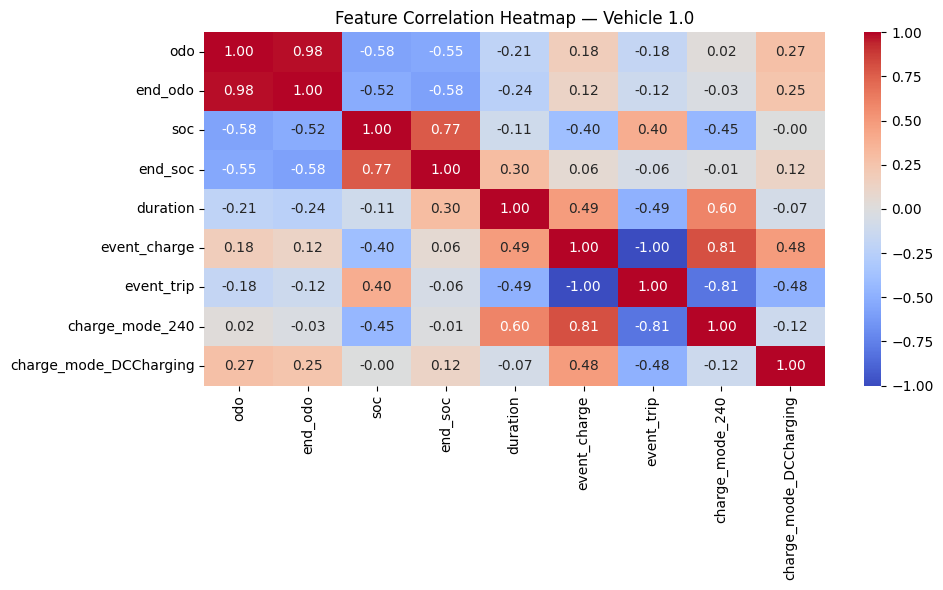

In [ ]:
for vehicle in vehicles:
    subset = data_encoded[data_encoded['vm'] == vm]

    numerical_data = subset[numerical_cols]

    if numerical_data.shape[0] < 2:
        continue 

    corr = numerical_data.corr()

    plt.figure(figsize=(10, 6))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
    plt.title(f'Feature Correlation Heatmap — Vehicle {vm}')
    plt.tight_layout()
    plt.show()

In [ ]:
data_encoded.to_csv('./Dataset_dumarey/preprocessed_dataset/dataset_rounded_OHE.csv', index=False)

# 2D Embedding

In [ ]:
data_embedded = data.copy()

In [ ]:
data_embedded.info()


<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 0 to 31
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   vm           30 non-null     Float64       
 1   timestamp    30 non-null     datetime64[ns]
 2   end_time     30 non-null     datetime64[ns]
 3   odo          30 non-null     float64       
 4   end_odo      30 non-null     float64       
 5   soc          30 non-null     float64       
 6   end_soc      30 non-null     float64       
 7   event        30 non-null     category      
 8   charge_mode  30 non-null     category      
 9   duration     30 non-null     float64       
 10  event_id     30 non-null     int64         
dtypes: Float64(1), category(2), datetime64[ns](2), float64(5), int64(1)
memory usage: 2.7 KB


In [ ]:
data_embedded.head()

,vm,timestamp,end_time,odo,end_odo,soc,end_soc,event,charge_mode,duration,event_id
0,1.0,2021-01-01 20:31:00,2021-01-01 20:38:00,4436.64,4439.47,56.4,54.9,trip,0,7.0,1
1,1.0,2021-01-01 20:39:00,2021-02-01 15:13:00,4439.47,4439.47,54.9,100.0,charge,240,44314.0,2
2,1.0,2021-02-01 15:13:00,2021-02-01 15:21:00,4439.47,4442.50,100.0,100.0,trip,0,8.0,3
3,1.0,2021-02-01 15:21:00,2021-02-01 17:46:00,4442.50,4457.13,100.0,94.5,trip,0,145.0,4
4,1.0,2021-02-01 17:46:00,2021-02-01 17:53:00,4457.13,4461.45,94.5,94.5,trip,0,7.0,5


In [ ]:
# === EMBEDDING PREPARATION ===
import torch
label_encoders = {}
cat_indices = {}
for col in cols_to_convert:
    le = LabelEncoder()
    cat_indices[col + "_idx"] = le.fit_transform(data_embedded[col].astype(str))
    label_encoders[col] = le

data_cat_idx = pd.DataFrame(cat_indices)
X_cat = torch.tensor(data_cat_idx.values, dtype=torch.long)

num_classes_per_cat = [len(label_encoders[col].classes_) for col in cols_to_convert]
embedding_dims = [2 for _ in num_classes_per_cat]  # oppure scegli dinamicamente

embedding_layers = nn.ModuleList([
    nn.Embedding(num_embeddings=n, embedding_dim=d)
    for n, d in zip(num_classes_per_cat, embedding_dims)
])

# 4. Applica gli embedding
embedded_parts = [embedding_layers[i](X_cat[:, i]) for i in range(X_cat.shape[1])]
embedded_features = torch.cat(embedded_parts, dim=1)  # [num_samples, total_emb_dim]

# Converti gli embedding in DataFrame
embedded_feature_names = []
for col, dim in zip(cols_to_convert, embedding_dims):
    embedded_feature_names.extend([f"{col}_emb_{i}" for i in range(dim)])

df_embedded = pd.DataFrame(embedded_features.detach().numpy(), columns=embedded_feature_names)


# === UNISCI CON LE FEATURE CONTINUE ===
# (escludi le colonne categoriche originali)
data_noncat = data_embedded.drop(columns=cols_to_convert).reset_index(drop=True)

# 7. Combina finali
data_embedded = pd.concat([data_noncat, df_embedded], axis=1)

In [ ]:
data_embedded.head()

,vm,timestamp,end_time,odo,end_odo,soc,end_soc,duration,event_id,event_emb_0,event_emb_1,charge_mode_emb_0,charge_mode_emb_1
0,1.0,2021-01-01 20:31:00,2021-01-01 20:38:00,4436.64,4439.47,56.4,54.9,7.0,1,-1.391773,1.509531,-0.410995,2.333605
1,1.0,2021-01-01 20:39:00,2021-02-01 15:13:00,4439.47,4439.47,54.9,100.0,44314.0,2,-1.359230,0.993220,1.409647,0.193869
2,1.0,2021-02-01 15:13:00,2021-02-01 15:21:00,4439.47,4442.50,100.0,100.0,8.0,3,-1.391773,1.509531,-0.410995,2.333605
3,1.0,2021-02-01 15:21:00,2021-02-01 17:46:00,4442.50,4457.13,100.0,94.5,145.0,4,-1.391773,1.509531,-0.410995,2.333605
4,1.0,2021-02-01 17:46:00,2021-02-01 17:53:00,4457.13,4461.45,94.5,94.5,7.0,5,-1.391773,1.509531,-0.410995,2.333605


In [ ]:
cols_to_convert = ['event_emb_0','event_emb_1', 'charge_mode_emb_0', 'charge_mode_emb_1']
data_embedded[cols_to_convert] = data_embedded[cols_to_convert].astype('float64')
data_embedded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   vm                 30 non-null     Float64       
 1   timestamp          30 non-null     datetime64[ns]
 2   end_time           30 non-null     datetime64[ns]
 3   odo                30 non-null     float64       
 4   end_odo            30 non-null     float64       
 5   soc                30 non-null     float64       
 6   end_soc            30 non-null     float64       
 7   duration           30 non-null     float64       
 8   event_id           30 non-null     int64         
 9   event_emb_0        30 non-null     float64       
 10  event_emb_1        30 non-null     float64       
 11  charge_mode_emb_0  30 non-null     float64       
 12  charge_mode_emb_1  30 non-null     float64       
dtypes: Float64(1), datetime64[ns](2), float64(9), int64(1)
memory usage

In [ ]:
data_embedded.to_csv('./Dataset_dumarey/preprocessed_dataset/dataset_rounded_2DE.csv', index=False)

### Timestamp Normalization to Hours Since Start

In [ ]:
#select the least recent date in timestamp
min_date = data_embedded['timestamp'].min()
#compute the difference in hour from the minimum date
data_embedded['timestamp'] = (data_embedded['timestamp'] - min_date).dt.total_seconds() / 3600
data_embedded['end_time'] = (data_embedded['end_time'] - min_date).dt.total_seconds() / 3600

In [ ]:
#selecting numerical columns
cols_to_exclude = ['vm', 'event_id']
numerical_cols = data_embedded.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in cols_to_exclude]

# Selecting only numerical columns for correlation
numerical_data = data_embedded[numerical_cols]
vehicles = data_embedded['vm'].unique()

### Feature Correlation Heatmap

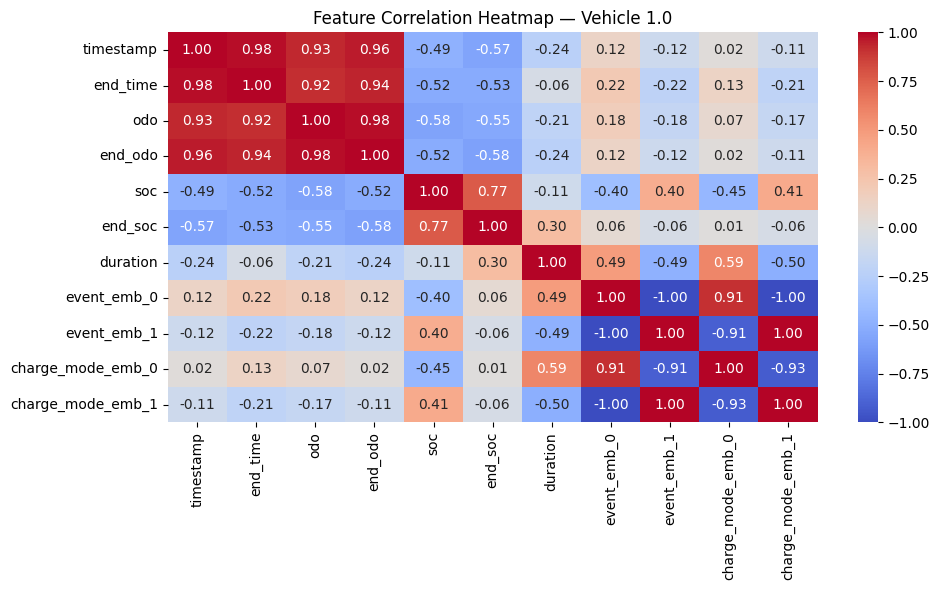

In [ ]:
for vehicle in vehicles:
    subset = data_embedded[data_encoded['vm'] == vm]

    numerical_data = subset[numerical_cols]

    if numerical_data.shape[0] < 2:
        continue 

    corr = numerical_data.corr()

    plt.figure(figsize=(10, 6))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
    plt.title(f'Feature Correlation Heatmap — Vehicle {vm}')
    plt.tight_layout()
    plt.show()


In [ ]:
data_embedded.to_csv('./Dataset_dumarey/preprocessed_dataset/dataset_rounded_2DE_time_norm.csv', index=False)

In [ ]:
# Ripristina i valori originali da data_embedded
data_embedded['event'] = label_encoders['event'].inverse_transform(data_cat_idx['event_idx'])
data_embedded['charge_mode'] = label_encoders['charge_mode'].inverse_transform(data_cat_idx['charge_mode_idx'])

# Rimuovi le colonne inutili (embedding e indici)
data_from_2DE_to_original = data_embedded.drop(columns=[
    'event_emb_0', 'event_emb_1',
    'charge_mode_emb_0', 'charge_mode_emb_1'
])

In [ ]:
data_from_2DE_to_original.head()

,vm,timestamp,end_time,odo,end_odo,soc,end_soc,duration,event_id,event,charge_mode
0,1.0,0.000000,0.116667,4436.64,4439.47,56.4,54.9,7.0,1,trip,0
1,1.0,0.133333,738.700000,4439.47,4439.47,54.9,100.0,44314.0,2,charge,240
2,1.0,738.700000,738.833333,4439.47,4442.50,100.0,100.0,8.0,3,trip,0
3,1.0,738.833333,741.250000,4442.50,4457.13,100.0,94.5,145.0,4,trip,0
4,1.0,741.250000,741.366667,4457.13,4461.45,94.5,94.5,7.0,5,trip,0


In [ ]:
cols_to_convert = ['event', 'charge_mode']
for col in cols_to_convert:
    data_from_2DE_to_original[col] = data_from_2DE_to_original[col].astype('category')
data_from_2DE_to_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   vm           30 non-null     Float64 
 1   timestamp    30 non-null     float64 
 2   end_time     30 non-null     float64 
 3   odo          30 non-null     float64 
 4   end_odo      30 non-null     float64 
 5   soc          30 non-null     float64 
 6   end_soc      30 non-null     float64 
 7   duration     30 non-null     float64 
 8   event_id     30 non-null     int64   
 9   event        30 non-null     category
 10  charge_mode  30 non-null     category
dtypes: Float64(1), category(2), float64(7), int64(1)
memory usage: 2.6 KB


- Trasformare gli object in float64 (Done)
- Capire come gestire le date (Done)
- Data fine evento si può convertire in durata evento? (ho inserito la data duration)
- Verificare se ci siano valori null (Done)
- Verificare se ci sono duplicati (Done)
- Fare feature correlation heatmap (Done)
- Onehot encoding (Done)
- Trasformare la colonna vm dato che si riferisce a singoli veicoli(ID) tipo in vec1 vec2 ecc
- Come gestisco i missing values?  
- come convertire gli embeddings dopo la generazione? (classificatore, nearest neighbor, from sklearn.metrics.pairwise import euclidean_distances)
